In [1]:
import rasterio
import numpy as np

In [4]:
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.profile

def calculate_trend(rasters):
    # Convert list of rasters to a 3D numpy array (time, rows, cols)
    stack = np.array(rasters)
    rows, cols = stack.shape[1], stack.shape[2]
    
    # Initialize an array to store the trends
    trend = np.zeros((rows, cols), dtype=np.float32)
    
    # Calculate the trend for each pixel
    for i in range(rows):
        for j in range(cols):
            pixel_values = stack[:, i, j]
            if np.all(np.isnan(pixel_values)):
                trend[i, j] = np.nan
            else:
                # Filter out NaN values
                valid_indices = np.isfinite(pixel_values)
                valid_pixel_values = pixel_values[valid_indices]
                valid_times = np.arange(len(pixel_values))[valid_indices]
                
                if len(valid_pixel_values) > 1:
                    try:
                        trend[i, j] = np.polyfit(valid_times, valid_pixel_values, 1)[0]
                    except np.linalg.LinAlgError:
                        trend[i, j] = np.nan
                else:
                    trend[i, j] = np.nan
    
    return trend

def main(raster_files, output_file):
    # Read the rasters and order them chronologically
    rasters = [read_raster(f)[0] for f in raster_files]
    profiles = [read_raster(f)[1] for f in raster_files]
    
    # Check that all rasters have the same shape
    if not all(r.shape == rasters[0].shape for r in rasters):
        raise ValueError("All rasters must have the same shape")
    
    # Calculate the trend for each pixel
    trend = calculate_trend(rasters)
    
    # Save the resulting trend raster
    output_profile = profiles[0]
    output_profile.update(dtype=rasterio.float32, count=1)
    
    with rasterio.open(output_file, 'w', **output_profile) as dst:
        dst.write(trend.astype(rasterio.float32), 1)

In [7]:
# Example usage
raster_files = [
    'C:/Users/Facu/Desktop/Malawi/Malawi_2019_complete.tif',
    'C:/Users/Facu/Desktop/Malawi/Malawi_2020_complete.tif',
    'C:/Users/Facu/Desktop/Malawi/Malawi_2021_complete.tif'
]

output_file = 'C:/Users/Facu/Desktop/Malawi/trend.tif'
main(raster_files, output_file)

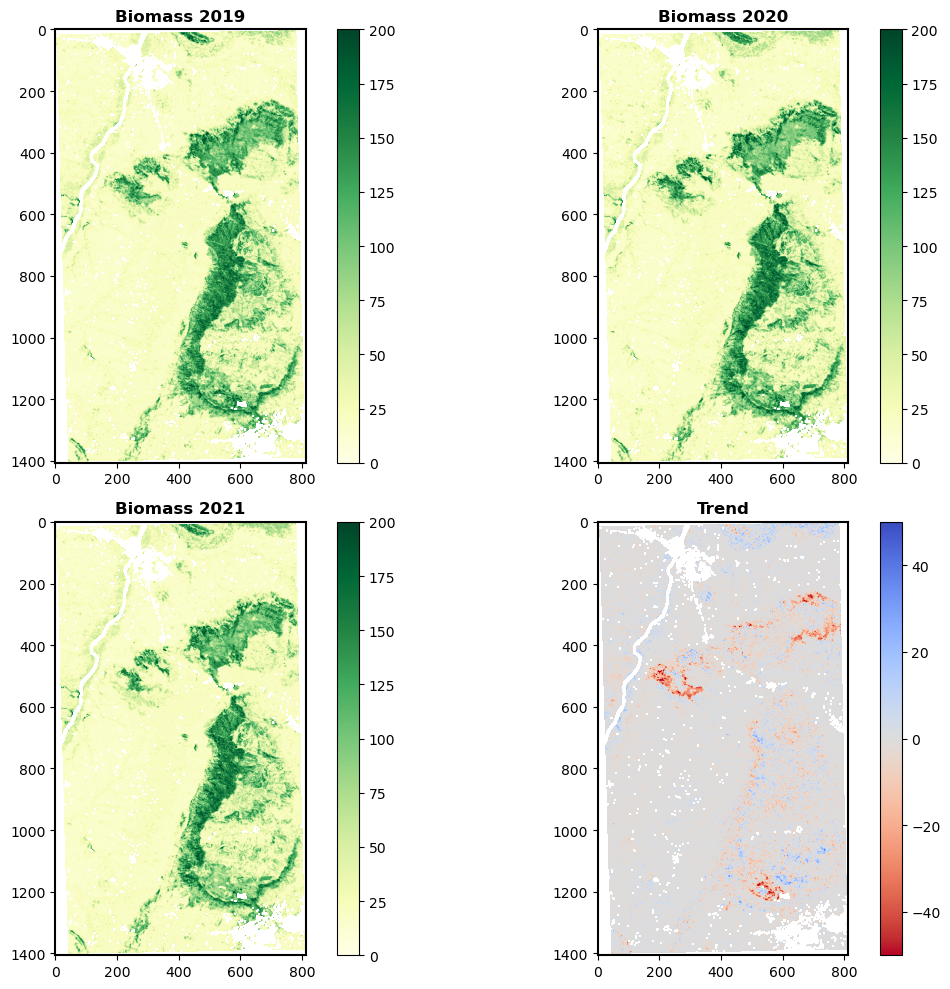

In [23]:
import matplotlib.pyplot as plt

raster_files = [
    'C:/Users/Facu/Desktop/Malawi/Malawi_2019_complete.tif',
    'C:/Users/Facu/Desktop/Malawi/Malawi_2020_complete.tif',
    'C:/Users/Facu/Desktop/Malawi/Malawi_2021_complete.tif',
    'C:/Users/Facu/Desktop/Malawi/trend.tif'
]

def plot_rasters(raster_files, titles, output_file):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, file in enumerate(raster_files):
        raster, profile = read_raster(file)
        ax = axes[i]
        if i < len(raster_files) - 1:
            img = ax.imshow(raster, cmap='YlGn', vmin=0, vmax=200)
        else:
            img = ax.imshow(raster, cmap='coolwarm_r', vmin=-50, vmax=50)
        ax.set_title(titles[i], fontweight='bold')
        fig.colorbar(img, ax=ax, orientation='vertical')
        # Agregar marco alrededor del subplot
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.savefig(output_file, dpi=300)  # Guardar el plot resultante
    plt.show()

titles = ['Biomass 2019', 'Biomass 2020', 'Biomass 2021', 'Trend']
output_file = 'C:/Users/Facu/Desktop/Malawi/combined_plot.png'

# Llamar a la función para plotear y guardar los rasters
plot_rasters(raster_files, titles, output_file)